# Deep Sets Tutorial

**Table of Contents:**
1. [Loading in the dataset]()
2. [Set up + train an architecture]()
3. [Other permutation invariant operators]()
4. [Including batch norm]()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

**Step 1:** Load in a preprocessed dataset

Since Fernando already covered data preprocessing in his tutorial, we'll start from a preprocessed dataset.

There are 15 features for each track, and jets that have less than 25 tracks are "padded" with zer






so pass a fixed dimensional input vectors, although these padded tracks will be ignored in the computation.


In [2]:
fDir = '/global/cfs/cdirs/ntrain5/atlas-ml-training/deep-sets-ftag-files/' 

In [3]:
nJets = '3m' 

dname = f'{fDir}/data_{nJets}train_25trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_ip3d_d0_ip3d_z0_sd0_rev.hdf5'

In [4]:
f = h5py.File(dname,"r")

nTrain = int(5e5)

X_train       = f['X_train'][:nTrain]
y_train       = f['y_train'][:nTrain]
ix_train      = f['ix_train'][:nTrain]
weights_train = f['weights_train'][:nTrain] # Weights to avoid learning directly from the pT dist


**Category definitions:** The y vector is the truth label for the jet:
- <span style="color:royalblue"> 0: light-jet </span>. 
- <span style="color:orange"> 1: c-jet </span>.
- <span style="color:limegreen"> 2: b-jet </span>
- <span style="color:crimson"> 3: $\tau$-jet </span> - but we'll remove these from the training set

In [5]:
nClasses = 3 # Only consider l, c, and b-jets

if y_train.max() >= nClasses:

    valid_targets = (y_train < nClasses)

    X_train       = X_train[valid_targets]
    y_train       = y_train[valid_targets]
    ix_train      = ix_train[valid_targets]
    weights_train = weights_train[valid_targets]
 

**Transform the input vector to a one-hot vector**

In [6]:
y_train[:4]

array([1., 0., 2., 2.])

In [7]:
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=nClasses)

In [8]:
y_train_cat[:4]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [9]:
X_train.shape

(477546, 25, 15)

**Step 2:** Set up a Deep Sets architecture

In [10]:
from tensorflow.keras.layers import BatchNormalization, Layer, TimeDistributed
from tensorflow.keras.layers import Dense, Input, ReLU, Masking
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

As Fernando explained, Keras is very modular and lets you stack layers like legos to build a custom architecture. For the Deep-Sets model, we just needed a custom layer to implement this sum over tracks, which is implemented in the block below.

In [11]:
class Sum(Layer):
    """
    Simple sum layer à la Dan Guest
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

**Set up the model skeleton** 

The model parameters are set as variables to be easy to train in the tutorial.

- ppm_sizes_int: A list defining the size for each of the dense layers of the per particle network Φ
- dense_sizes_int: A list defining the size for each of the dense layers of the per particle network F

In [12]:
# Store the dimensions of the input dataset for setting up the model
nJets, maxNumTrks, nFeatures = X_train.shape

**TO DO:** Include a picture of an architecture and _ask_ them to implement it!

In [13]:
ppm_sizes_int = [50,50,32]
dense_sizes_int = [50,50]

In [14]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Sum(name="Sum")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips = Model(inputs=trk_inputs, outputs=output)

2022-07-26 18:29:32.732550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/esslurm/lib64:/opt/cray/pe/papi/6.0.0.12/lib64:/opt/cray/job/2.2.4-7.0.3.1_3.20__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.2.254/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.2.254/linux/mkl/lib/intel64:/global/common/cori_cle7up03/software/darshan/3.3.1/lib
2022-07-26 18:29:32.742966: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/esslurm/lib64:/opt/cray/pe/papi/6.0.0.12/lib64:/opt/cray/job/2.2.4-7.0.3.1_3.20__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.2.254/linux/compiler/lib/intel64:/opt/intel/compilers_and_librari

In [15]:
for l in dips.layers:
    print(l.name, l.supports_masking)

input_1 True
masking True
Phi0_Dense True
Phi0_ReLU True
Phi1_Dense True
Phi1_ReLU True
Phi2_Dense True
Phi2_ReLU True
Sum True
F0_Dense True
F0_ReLU True
F1_Dense True
F1_ReLU True
Jet_class True


As a sanitry check, you can check the structure of the model.

In [16]:
dips.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 15)]          0         
                                                                 
 masking (Masking)           (None, 25, 15)            0         
                                                                 
 Phi0_Dense (TimeDistributed  (None, 25, 50)           800       
 )                                                               
                                                                 
 Phi0_ReLU (TimeDistributed)  (None, 25, 50)           0         
                                                                 
 Phi1_Dense (TimeDistributed  (None, 25, 50)           2550      
 )                                                               
                                                                 
 Phi1_ReLU (TimeDistributed)  (None, 25, 50)           0     

To train the model, you need to define what you mean by a model performing better or worse, which we quantify by a loss function. For multi-class classification, we use the categorical cross-entropy, which maximizes the node corresponding to the true label of the jet.You also need a strategy for updating the weights as you minimize the loss, which is inside the optimizer. There are many different optimization strategies on the market and available in Keras, but the optimizer adam is often a good one to start with since it provides a way to decrease the weight update as you converge onto a solution.This is what is done in the "compile" function below.

In [17]:
dips.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['acc'])  

**Warm up Q:** _Before training_ the model, what do you think the accuracy will be?


- A.   0% 
- B.   33%
- C.   50%
- D.   100%

**Test your answer above:** 

In [18]:
dips.evaluate(X_train,y_train_cat,batch_size=128)

3731/3731 [==============================] - 7s 2ms/step - loss: 1.5637 - acc: 0.3609


[1.5637437105178833, 0.36085739731788635]

The second number above is the accuracy, which is close to 1/3, since before training the model is just guessing among the three outputs.The first number is the loss, which gets minimized in the training.

**Training details**

When training a model, how do you decide how long to go for? When training NNs, you look at your training dataset multiple times as you converge to a solution. A single pass over the training dataset is called an epoch.

The model nEpochs is set at 5 right now and is a variable for the maximimum number of epochs, but in practice, it's common to set this value to something larger, and use the loss on a separate validation dataset to decide when to stop training. This is set up in the EarlyStopping callback which says to stop training when the loss on the validation dataset (val_loss) has not improved in 10 epochs.

Then the ModelCheckpoint below saves the name for the model weights file you're using.

In [19]:
nEpochs = 5

earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)

dips_mChkPt = ModelCheckpoint('dips_weights.h5',
                              monitor='val_loss', 
                              verbose=True,
                              save_best_only=True,
                              save_weights_only=True)

In [20]:
dips_hist = dips.fit(X_train, y_train_cat, epochs=nEpochs, 
                     batch_size=128,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
2978/2985 [============================>.] - ETA: 0s - loss: 0.4940 - acc: 0.8295
Epoch 1: val_loss improved from inf to 0.47164, saving model to dips_weights.h5
2985/2985 [==============================] - 17s 5ms/step - loss: 0.4940 - acc: 0.8295 - val_loss: 0.4716 - val_acc: 0.8375
Epoch 2/5
2981/2985 [============================>.] - ETA: 0s - loss: 0.4643 - acc: 0.8391
Epoch 2: val_loss improved from 0.47164 to 0.46478, saving model to dips_weights.h5
2985/2985 [==============================] - 16s 5ms/step - loss: 0.4643 - acc: 0.8392 - val_loss: 0.4648 - val_acc: 0.8384
Epoch 3/5
2981/2985 [============================>.] - ETA: 0s - loss: 0.4568 - acc: 0.8412
Epoch 3: val_loss improved from 0.46478 to 0.45958, saving model to dips_weights.h5
2985/2985 [==============================] - 16s 5ms/step - loss: 0.4568 - acc: 0.8412 - val_loss: 0.4596 - val_acc: 0.8403
Epoch 4/5
2974/2985 [============================>.] - ETA: 0s - loss: 0.4531 - acc: 0.8428
Epoch 4: val

Let's look at the training curve!

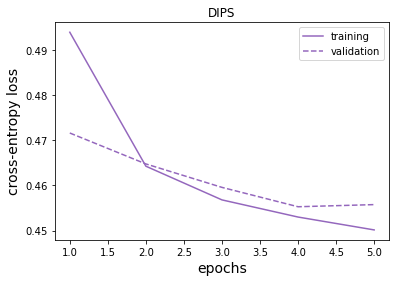

In [21]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)

plt.plot(epochs,dips_hist.history['loss'],color='C4',label='training')
plt.plot(epochs,dips_hist.history['val_loss'],color='C4',label='validation',ls='--')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS')

plt.show()

Since only 500k jets are being used in the training rn, the model might be overfitting a bit for these hyperparameters.

**Evaluate the results with a roc curve**

For this multiclass output problem, we'll combine the three class probabilities into a single discriminant.

$$D_b = \log \frac{p_b}{f_c \cdot p_c + (1 - f_c) \cdot p_l}$$

where $f_c$ is the "charm fraction" which is a parameter we choose after training the network.

For this tutorial we will set $f_c = 0.07$.


**(Warm up) question:** Will a $b$-jet have high or low values of $D_b$?

-> High values of $D_b$

What about $c$ and $l$-jets?

-> Low values of $D_b$

**Test your assumption** The code below does the roc curve calculation.

TO DO: Fill in the discriminant calculation (the line below starting with)

`disc = ...` 

In [26]:
def sigBkgEff(myModel, X_test, y_test, fc=0.07, title=''):
    '''
    Given a model, make the histograms of the model outputs to get the ROC curves.

    Input:
        myModel: A keras model
        X_test: Model inputs of the test set
        y_test: Truth labels for the test set
        fc: The amount by which to weight the c-jet prob in the disc. The
            default value of 0.07 corresponds to the fraction of c-jet bkg
            in ttbar.

    Output:
        effs: A list with 3 entries for the l, c, and b effs
    '''

    # Evaluate the performance with the ROC curves!
    predictions = myModel.predict(X_test,verbose=True)

    '''
    TO DO: Set up the discriminant function
    '''
    disc = np.log(np.divide(predictions[:,2], fc*predictions[:,1] + (1 - fc) * predictions[:,0]))
    
    # Define the min and max range for the distribution
    discMax = np.max(disc)
    discMin = np.min(disc)
    
    myRange=(discMin,discMax)
    nBins = 200

    effs = []
    for output, flavor in zip([0,1,2], ['l','c','b']):

        ix = (y_test == output)
        
        # Plot the discriminant output
        # nEntries is just a sum of the weight of each bin in the histogram.
        nEntries, edges ,_ = plt.hist(disc[ix],alpha=0.5,label='{}-jets'.format(flavor),
                                      bins=nBins, range=myRange, density=True, log=True)
        
        # Since high Db scores correspond to more b-like jets, compute the cummulative density function
        # from summing from high to low values, this is why we reverse the order of the bins in nEntries
        # using the "::-1" numpy indexing.
        eff = np.add.accumulate(nEntries[::-1]) / np.sum(nEntries)
        effs.append(eff)

    plt.title(title)
    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('Normalized entries')
        
    return effs


In [27]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 1000000

X_test = f['X_train'][:nTest]
y_test = f['y_train'][:nTest]

In [28]:
ppm_sizes_int

[50, 50, 32]

31250/31250 [==============================] - 34s 1ms/step


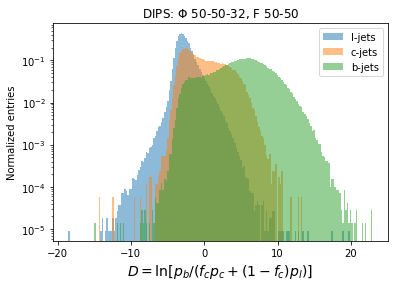

In [30]:
title = 'DIPS: $\Phi$ ' + '-'.join([str(i) for i in ppm_sizes_int])
title += ', F ' + '-'.join([str(i) for i in dense_sizes_int])

leff, ceff, beff = sigBkgEff(dips, X_test, y_test, title=title)

/tmp/ipykernel_66069/2647297232.py:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(beff, 1 / leff, color='C4', label='dips: l-rej')
/tmp/ipykernel_66069/2647297232.py:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')
/tmp/ipykernel_66069/2647297232.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,int(2e3))


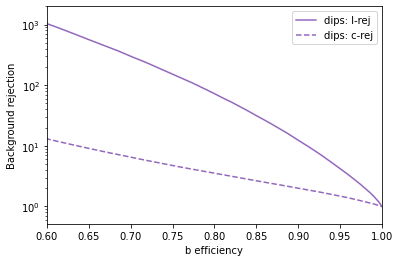

In [31]:
# l-rej
plt.figure()
plt.plot(beff, 1 / leff, color='C4', label='dips: l-rej')

# c-rej
plt.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
#plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(2e3))

plt.show()

**Step 3:** Test out other permutation invariant operations

- max
- mean

**Hint(s):** 
- Use the Sum() layer above for inspiration
- Try typing K. and press the tab completion to see what other functions are available

In [33]:
'''
Will be left blank for the students
'''

class Max(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.max(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

In [34]:
'''
Will be left blank for the students
'''

class Mean(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.mean(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

**Try training these models and see how they compare:**

It's fine to use the same hyperparameters as above for the $\Phi$ and $F$ networks to just compare the impact of the pooling operation.

In [35]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Max(name="Max")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)

'''
All but the last line here will be left blank for the students
'''

dips_max = Model(inputs=trk_inputs, outputs=output)

In [36]:
dips_max.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['acc'])  

dips_hist_max = dips_max.fit(X_train, y_train_cat, epochs=nEpochs, 
                         batch_size=128,validation_split=0.2,
                         callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
2979/2985 [============================>.] - ETA: 0s - loss: 0.5085 - acc: 0.8246
Epoch 1: val_loss did not improve from 0.45529
2985/2985 [==============================] - 17s 6ms/step - loss: 0.5085 - acc: 0.8246 - val_loss: 0.4767 - val_acc: 0.8344
Epoch 2/5
2976/2985 [============================>.] - ETA: 0s - loss: 0.4734 - acc: 0.8363
Epoch 2: val_loss did not improve from 0.45529
2985/2985 [==============================] - 16s 5ms/step - loss: 0.4733 - acc: 0.8364 - val_loss: 0.4745 - val_acc: 0.8357
Epoch 3/5
2984/2985 [============================>.] - ETA: 0s - loss: 0.4671 - acc: 0.8379
Epoch 3: val_loss did not improve from 0.45529
2985/2985 [==============================] - 16s 5ms/step - loss: 0.4671 - acc: 0.8379 - val_loss: 0.4722 - val_acc: 0.8359
Epoch 4/5
2980/2985 [============================>.] - ETA: 0s - loss: 0.4629 - acc: 0.8395
Epoch 4: val_loss did not improve from 0.45529
2985/2985 [==============================] - 17s 6ms/step - loss: 0.4631

In [37]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Mean(name="Mean")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)

'''
All but the last line here will be left blank for the students
'''

dips_mean = Model(inputs=trk_inputs, outputs=output)

In [38]:
dips_mean.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['acc'])  

dips_hist_mean = dips_mean.fit(X_train, y_train_cat, epochs=nEpochs, 
                     batch_size=128,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
2978/2985 [============================>.] - ETA: 0s - loss: 0.4967 - acc: 0.8293
Epoch 1: val_loss did not improve from 0.45529
2985/2985 [==============================] - 17s 6ms/step - loss: 0.4966 - acc: 0.8293 - val_loss: 0.4759 - val_acc: 0.8345
Epoch 2/5
2984/2985 [============================>.] - ETA: 0s - loss: 0.4648 - acc: 0.8392
Epoch 2: val_loss did not improve from 0.45529
2985/2985 [==============================] - 17s 6ms/step - loss: 0.4648 - acc: 0.8392 - val_loss: 0.4644 - val_acc: 0.8385
Epoch 3/5
2978/2985 [============================>.] - ETA: 0s - loss: 0.4582 - acc: 0.8406
Epoch 3: val_loss did not improve from 0.45529
2985/2985 [==============================] - 17s 6ms/step - loss: 0.4581 - acc: 0.8407 - val_loss: 0.4566 - val_acc: 0.8414
Epoch 4/5
2979/2985 [============================>.] - ETA: 0s - loss: 0.4542 - acc: 0.8424
Epoch 4: val_loss did not improve from 0.45529
2985/2985 [==============================] - 15s 5ms/step - loss: 0.4542

**Which of these 3 models is doing the best?** 

Initial check: Compare the loss curves.

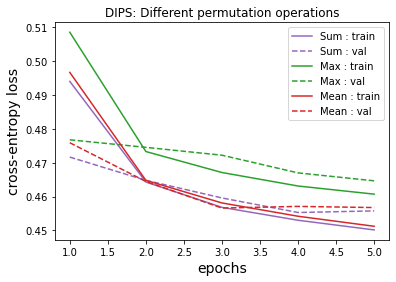

In [54]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)


for h,c,l in zip([dips_hist, dips_hist_max, dips_hist_mean],
                 ['C4','C2','C3'],['Sum','Max','Mean']):
    plt.plot(epochs,h.history['loss'],color=c,label=f'{l} : train')
    plt.plot(epochs,h.history['val_loss'],color=c,label=f'{l} : val',ls='--')
    
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS: Different permutation operations')

plt.show()

Next: compare the roc curves on the test set

31250/31250 [==============================] - 35s 1ms/step


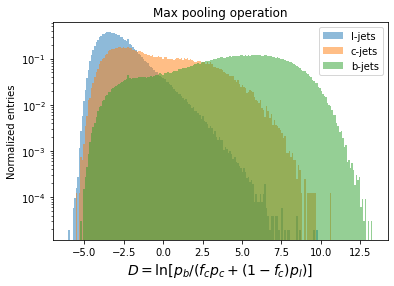

In [40]:
leff_max, ceff_max, beff_max = sigBkgEff(dips_max, X_test, y_test, 
                                         title='Max pooling operation')

31250/31250 [==============================] - 35s 1ms/step


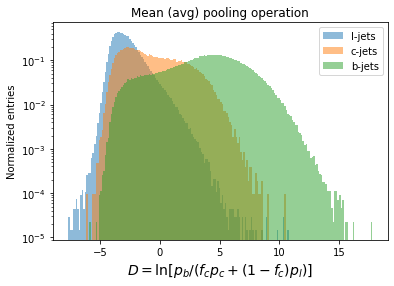

In [41]:
leff_mean, ceff_mean, beff_mean = sigBkgEff(dips_mean, X_test, y_test, 
                                            title='Mean (avg) pooling operation')

/tmp/ipykernel_66069/2327736129.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_66069/2327736129.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_66069/2327736129.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_66069/2327736129.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_66069/2327736129.py:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/tmp/ipykernel_66069/2327736129.py:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/tmp/ipykernel_66069/2327736129.py:18: UserWarning: Att

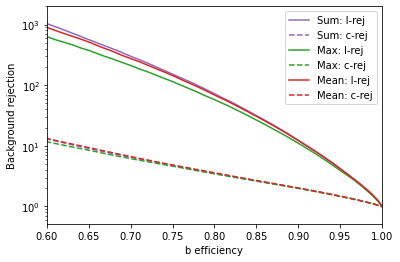

In [42]:
plt.figure()

for bi,li,ci,c, l in zip([beff,beff_max,beff_mean],[leff,leff_max,leff_mean],
                         [ceff,ceff_max,ceff_mean],['C4','C2','C3'],['Sum','Max','Mean']):

    # l-rej
    plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')

    # c-rej
    plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
#plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(2e3))

plt.show()

**Q1:** Which is the least performant model?

-> The Max pooling operation 

**Q2** Why might this model be doing not as good?

-> By just taking the max over the features, we're loosing information from the features for many of the jets.

Try adding `ntrks` as a feature to the Max model and see if the performance is recovered

How to calculate `ntrks`?

Recall, the shape of X_train is (nJets, maxNumTrks, nFeatures) 
and for jets that have fewer than maxNumTrks tracks, the features
for this "blank" track will all be padded with zeros.


In [43]:
X_train.shape

(477546, 25, 15)

Hint: Try using the np.any function to calculate the number of tracks for each jet in X_train

In [44]:
tmask = ~np.all(X_train==0, axis=-1) # False for a padded track

ntrks = np.sum(tmask,axis=1)

In [45]:
ntrks

array([6, 5, 9, ..., 4, 9, 4])

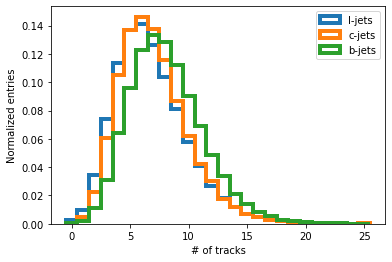

In [46]:
plt.hist(ntrks[y_train==0],26,(-0.5,25.5),histtype='step',lw=4,label='l-jets',density=True)
plt.hist(ntrks[y_train==1],26,(-0.5,25.5),histtype='step',lw=4,label='c-jets',density=True)
plt.hist(ntrks[y_train==2],26,(-0.5,25.5),histtype='step',lw=4,label='b-jets',density=True)

plt.xlabel('# of tracks')
plt.ylabel('Normalized entries')
plt.legend()
plt.show()

In [47]:
ntrks.shape

(477546,)

In [48]:
X_train.shape

(477546, 25, 15)

In [49]:
# Broadcast the # of tracks in the jet across the track features
ntrks_broad = np.vstack([ntrks]*maxNumTrks).T

# But need to mask it
ntrks_broad = ntrks_broad * tmask

In [50]:
X_train_exp = np.dstack([X_train, ntrks_broad])

X_train_exp.shape

(477546, 25, 16)

In [59]:
ppm_sizes_int

[50, 50, 32]

In [60]:
dense_sizes_int

[50, 50]

In [51]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures+1))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Max(name="Mean")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips_max_exp = Model(inputs=trk_inputs, outputs=output)

In [53]:
dips_max_exp.compile(loss='categorical_crossentropy', optimizer='adam',
                     metrics=['acc'])  

dips_hist_max_exp = dips_max_exp.fit(X_train_exp, y_train_cat, epochs=nEpochs, 
                             batch_size=128,validation_split=0.2,
                             callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
2981/2985 [============================>.] - ETA: 0s - loss: 0.5151 - acc: 0.8219
Epoch 1: val_loss did not improve from 0.45529
2985/2985 [==============================] - 17s 6ms/step - loss: 0.5151 - acc: 0.8219 - val_loss: 0.4843 - val_acc: 0.8313
Epoch 2/5
2984/2985 [============================>.] - ETA: 0s - loss: 0.4778 - acc: 0.8342
Epoch 2: val_loss did not improve from 0.45529
2985/2985 [==============================] - 16s 5ms/step - loss: 0.4778 - acc: 0.8342 - val_loss: 0.4822 - val_acc: 0.8333
Epoch 3/5
2984/2985 [============================>.] - ETA: 0s - loss: 0.4712 - acc: 0.8371
Epoch 3: val_loss did not improve from 0.45529
2985/2985 [==============================] - 18s 6ms/step - loss: 0.4712 - acc: 0.8371 - val_loss: 0.4731 - val_acc: 0.8365
Epoch 4/5
2979/2985 [============================>.] - ETA: 0s - loss: 0.4670 - acc: 0.8381
Epoch 4: val_loss did not improve from 0.45529
2985/2985 [==============================] - 16s 5ms/step - loss: 0.4671

**Compare traiig curves**

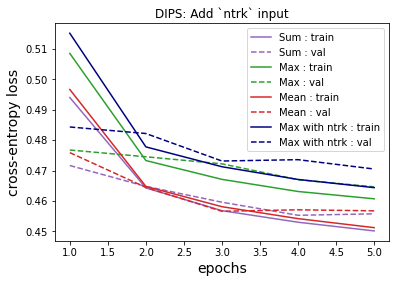

In [58]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)


for h,c,l in zip([dips_hist, dips_hist_max, dips_hist_mean, dips_hist_max_exp],
                 ['C4','C2','C3','navy'],['Sum','Max','Mean','Max with ntrk']):
    
    plt.plot(epochs,h.history['loss'],color=c,label=f'{l} : train')
    plt.plot(epochs,h.history['val_loss'],color=c,label=f'{l} : val',ls='--')
    
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS: Add `ntrk` input')

plt.show()

**Compare roc curves**

In [62]:
# leff_max_exp, ceff_max_exp, beff_max_exp = sigBkgEff(dips_max_exp, X_test_exp, y_test, 
#                                          title='Max pooling w/ ntrk')

In [ ]:
plt.figure()

for bi,li,ci,c, l in zip([beff,beff_max,beff_mean,beff_max_],
                         [leff,leff_max,leff_mean],
                         [ceff,ceff_max,ceff_mean],
                         ['C4','C2','C3'],['Sum','Max','Mean']):

    # l-rej
    plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')

    # c-rej
    plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
#plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(2e3))

plt.show()

**Step 4:** Test out batch norm

- batch_norm: Whether or not to use BatchNormalization, a regularization tecnique for deep models. The key idea is that it's easier for models to train if the input are bell shaped and centered around 0 to take advantage of the non-linearity. This is why we normalize the inputs in the pre-processing, and the Batch-Normalization is a technique which normalized the outputs from a network layer so that the next layer has nicely scaled inputs for the training. 